# Sounds Like
Find a song that sounds like something you would love to listen to

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests
import zipfile
import tarfile

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from utils.converter import h5_to_dict
from pathlib import Path

In [2]:
# Create the data directory
Path.mkdir(Path("data"), exist_ok=True)

In [3]:
OUTPUT_CSV_PATH = "data/songs.csv"
INPUT_FILE_PATH = "data/MillionSongSubset"

## Download resources

You will need to download all of these resources before you can continue. Altogether, you will need at most 4 GB of storage available. If you prefer not doing it yourself, the next cell after this will automatically download and extract everything. However, it will take noticeably longer to uncompress the data.

1. [Million Song Subset](http://labrosa.ee.columbia.edu/~dpwe/tmp/millionsongsubset.tar.gz")
2. [Sample Track](http://millionsongdataset.com/sites/default/files/AdditionalFiles/TRAXLZU12903D05F94.h5)
3. [Taste Profile](http://labrosa.ee.columbia.edu/~dpwe/tmp/train_triplets.txt.zip)
4. [Mismatched tracks](http://millionsongdataset.com/sites/default/files/tasteprofile/sid_mismatches.txt)

Running the cell below will **override any existing resources in the data folder**.

In [ ]:
RESOURCES = [
    "http://millionsongdataset.com/sites/default/files/tasteprofile/sid_mismatches.txt",
    "http://labrosa.ee.columbia.edu/~dpwe/tmp/train_triplets.txt.zip",
    "http://labrosa.ee.columbia.edu/~dpwe/tmp/millionsongsubset.tar.gz",
    "http://millionsongdataset.com/sites/default/files/AdditionalFiles/TRAXLZU12903D05F94.h5",
    "http://millionsongdataset.com/sites/default/files/thisismyjam/jam_to_msd.tsv",
    "https://archive.org/download/thisismyjam-datadump/thisismyjam-datadump.zip"
]

files_downloaded = 0

for resource in RESOURCES:
    # Download all resources
    local_filename = resource[resource.rindex("/") + 1:]

    try:
        with requests.get(resource, stream=True) as r:
            r.raise_for_status()

            with open(f"data/{local_filename}", "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        
        files_downloaded += 1
    except Exception as e:
        print(f"Failed to download resource - {resource}.\nError: {e}\nDO NOT PROCEED TO THE NEXT CELL.")
        break

print(f"{files_downloaded} of {len(RESOURCES)} resources(s) downloaded")

if files_downloaded == len(RESOURCES):
    # Extract compressed resources
    with tarfile.open("data/millionsongsubset.tar.gz", "r:gz") as tar:
        tar.extractall("data/")
    with zipfile.ZipFile("data/train_triplets.txt.zip", "r") as zip:
        zip.extractall("data/")
    with zipfile.ZipFile("data/thisismyjam-datadump.zip", "r") as zip:
        zip.extractall("data/")
    
    # Delete the zip files
    os.remove("data/millionsongsubset.tar.gz")
    os.remove("data/train_triplets.txt.zip")
    os.remove("data/thisismyjam-datadump.zip")
    
    print("Done. All data uncompressed successfully.")

4 of 4 resources(s) downloaded


## Import data
If you already have the song dataset ready as a pandas dataframe, then you can skip Cell 4 and start executing from Cell 5 to import your data. If you do not have a pandas dataframe containing your songs yet, you must run Cell 4 if you need to convert the HDF5 files in the MillionSong dataset into a pandas dataframe.

In [ ]:
# RUN !!ONLY!! THIS (AND NOT THE CELL BELOW) IF songs.csv DOES NOT EXIST in your data/ folder
# This will take approximately 10 minutes for 10,000 records.
rows = []

for root, _, files in os.walk(INPUT_FILE_PATH):
	for file in files:
		h5_path = os.path.join(root, file)
		try:
			song_data = h5_to_dict(h5_path)
			rows.append(song_data)
		except Exception as e :
			print(f"Error loading file {file}: {e}")

df = pd.DataFrame(rows)
df.to_csv(OUTPUT_CSV_PATH , index=False)

print(f"CSV created: {OUTPUT_CSV_PATH}")

In [4]:
# RUN !!ONLY!! THIS (AND NOT THE CELL ABOVE) IF songs.csv ALREADY EXISTS IN YOUR data/ folder
df = pd.read_csv("data/songs.csv")
df[["analysis/songs/key", "analysis/songs/mode"]].head(10)

,analysis/songs/key,analysis/songs/mode
0,1,0
1,6,0
2,8,1
3,0,1
4,2,1
5,5,1
6,1,1
7,4,0
8,4,1
9,7,0


## Transform Taste Profile Subset

In order to create vector embeddings for our tracks, we will have to first transform the taste profile subset such that it contains the top 5 tracks of each user.

In [ ]:
# Reshape Taste Profile subset 
temp_df = pd.read_csv("data/train_triplets.txt", delimiter="\t", names=["user_id", "song_id", "play_count"])
temp_df = temp_df.sort_values(by=["user_id", "play_count"], ascending=[True, False])

top_songs = temp_df.groupby("user_id").head(5)
result = top_songs.groupby("user_id")["song_id"].apply(list).reset_index()
result.columns = ["User", "Top 5 Tracks"]

result.to_csv("data/taste_profile.csv", index=False)

KeyError: 'user_id'

# Some basics in pandas and numpy

Reshaping matrices or arrays allows you to modify its dimensions.

If you need to produce a dataframe with only one feature then the best way to do it is `df[["feature"]]`. You can also use the same method to generate a dataframe with a subset of its original columns. Simply enter the columns you wish to select in the list like `df[["feature_1", "feature_2"]]`. The numpy equivalent of this is `np.reshape(df, (-1, 1))`. However, the disadvantage of using numpy is that the feature's names are not preserved.

In [162]:
print(df.columns)

Index(['analysis/bars_confidence', 'analysis/bars_start',
       'analysis/beats_confidence', 'analysis/beats_start',
       'analysis/sections_confidence', 'analysis/sections_start',
       'analysis/segments_confidence', 'analysis/segments_loudness_max',
       'analysis/segments_loudness_max_time',
       'analysis/segments_loudness_start', 'analysis/segments_pitches',
       'analysis/segments_start', 'analysis/segments_timbre',
       'analysis/songs/analysis_sample_rate',
       'analysis/songs/idx_sections_confidence',
       'analysis/songs/idx_sections_start',
       'analysis/songs/idx_segments_confidence',
       'analysis/songs/idx_segments_loudness_max',
       'analysis/songs/idx_segments_loudness_max_time',
       'analysis/songs/idx_segments_loudness_start',
       'analysis/songs/idx_segments_pitches',
       'analysis/songs/idx_segments_start',
       'analysis/songs/idx_segments_timbre',
       'analysis/songs/idx_tatums_confidence', 'analysis/songs/audio_md5',
     

(array([  28.,  104.,  533., 2787., 2925., 1970., 1091.,  429.,  105.,
          28.]),
 array([-3.49363792, -2.7465993 , -1.99956068, -1.25252207, -0.50548345,
         0.24155516,  0.98859378,  1.73563239,  2.48267101,  3.22970962,
         3.97674824]),
 <BarContainer object of 10 artists>)

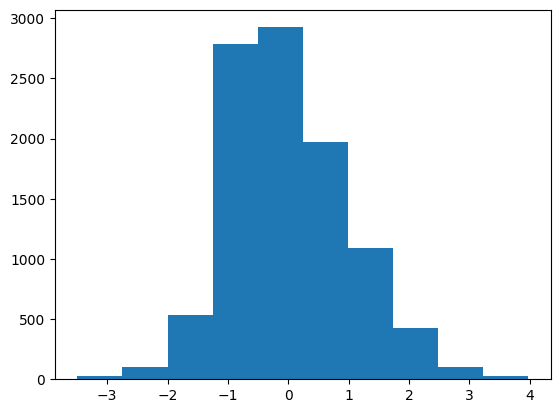

In [163]:
plt.hist(df["analysis/songs/tempo"])

(array([2.000e+00, 3.000e+00, 1.100e+01, 3.700e+01, 1.380e+02, 3.750e+02,
        1.095e+03, 2.936e+03, 4.560e+03, 8.430e+02]),
 array([-7.6224081 , -6.6554885 , -5.6885689 , -4.7216493 , -3.7547297 ,
        -2.78781011, -1.82089051, -0.85397091,  0.11294869,  1.07986829,
         2.04678788]),
 <BarContainer object of 10 artists>)

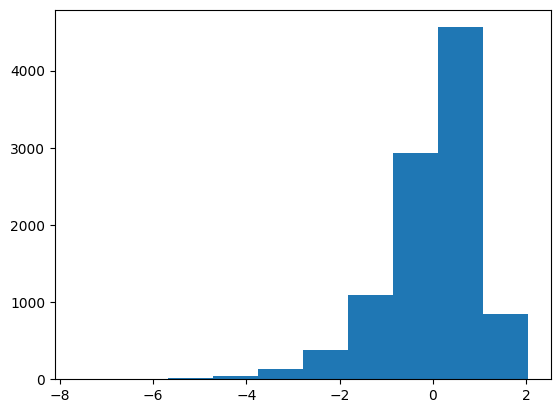

In [164]:
plt.hist(df["analysis/songs/loudness"])

## Key
The key of the song where 0 represents C, 1 represents D and so on.

[Ref.](https://stackoverflow.com/questions/32202589/pyechonest-how-to-interpret-key-and-mode-attributes)

(array([2034., 1129.,  310.,  810.,  795.,  577., 1339.,  528., 1040.,
        1438.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

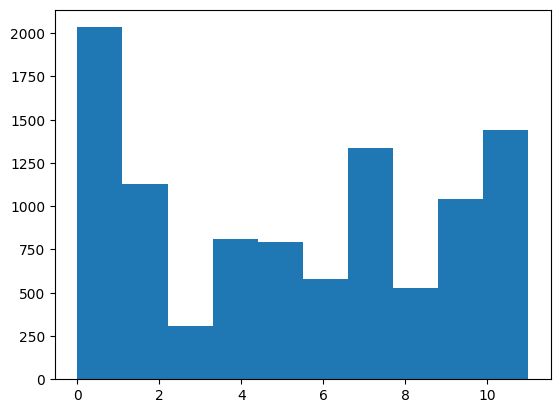

In [165]:
plt.hist(df["analysis/songs/key"])

(array([2.823e+03, 6.313e+03, 7.020e+02, 1.000e+02, 2.800e+01, 1.600e+01,
        8.000e+00, 4.000e+00, 3.000e+00, 3.000e+00]),
 array([-2.08060387, -0.48707502,  1.10645384,  2.69998269,  4.29351155,
         5.8870404 ,  7.48056926,  9.07409811, 10.66762697, 12.26115582,
        13.85468468]),
 <BarContainer object of 10 artists>)

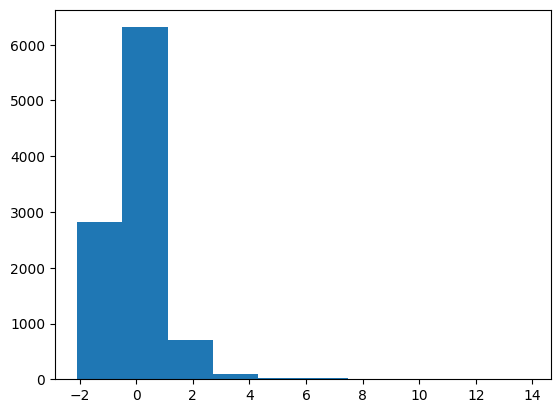

In [166]:
plt.hist(df["analysis/songs/duration"])

## Mode
Indicates if the track is in the major key or minor key. In other words, a track is said to be in C Major if its key is 0 and its mode is 1.

[Ref.](https://stackoverflow.com/questions/32202589/pyechonest-how-to-interpret-key-and-mode-attributes)

(array([3089.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6911.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

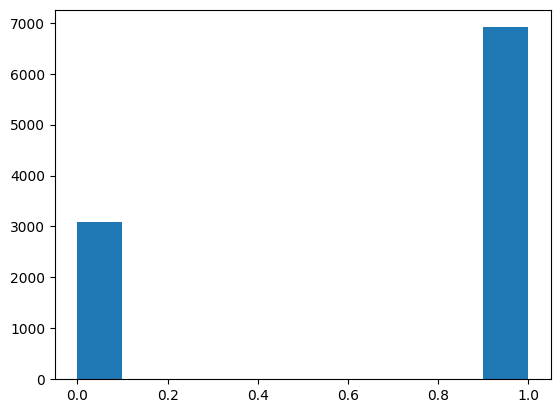

In [167]:
plt.hist(df["analysis/songs/mode"])

(array([3.000e+00, 1.498e+03, 0.000e+00, 0.000e+00, 1.278e+03, 6.351e+03,
        0.000e+00, 5.890e+02, 0.000e+00, 2.810e+02]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

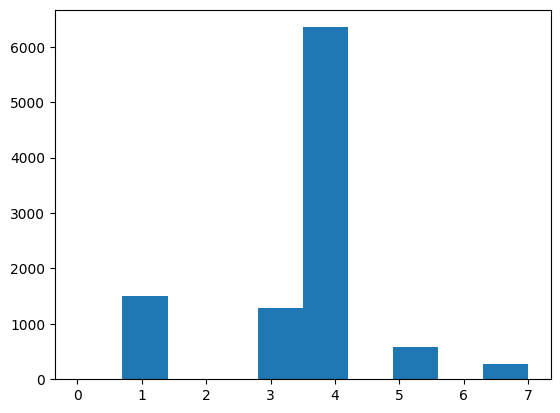

In [168]:
plt.hist(df["analysis/songs/time_signature"])

## One Hot Encoding
As it currently stands, some categorical features exist in numerical formats which can cause the model to infer incorrect relationships. Taking key as an example, the model should not assume that there is some kind of increasing relationship from one key to the next but rather treat each key individually as separate features. Making multiple features for each key can be computationally expensive which is why we opt to create one-hot-encodings instead.

[Learn more](https://developers.google.com/machine-learning/crash-course/categorical-data/one-hot-encoding)

In [169]:
# Create one-hot encoding vectors
encoder = OneHotEncoder(sparse_output=False)
encoder.set_output(transform="pandas")

df_encoded_keys = encoder.fit_transform(df[["analysis/songs/key"]])
df_encoded_mode = encoder.fit_transform(df[["analysis/songs/mode"]])

df = pd.concat([df, df_encoded_keys, df_encoded_mode], axis=1)

## Normalization

Some features need to be normalized to a common range to improve the model. Most features with an even distribution will be normalized using the Standard Scaler (Z-score distribution).

[Learn more](https://developers.google.com/machine-learning/crash-course/numerical-data/normalization)

In [174]:
# Apply the StandardScaler to normalize datapoints in the tempo column using Z-score distribution
scaler = StandardScaler()

df["analysis/songs/tempo"] = scaler.fit_transform(df[["analysis/songs/tempo"]])
df["analysis/songs/loudness"] = scaler.fit_transform(df[["analysis/songs/loudness"]])
df["analysis/songs/duration"] = scaler.fit_transform(df[["analysis/songs/duration"]])

(array([  28.,  104.,  533., 2787., 2925., 1970., 1091.,  429.,  105.,
          28.]),
 array([-3.49363792, -2.7465993 , -1.99956068, -1.25252207, -0.50548345,
         0.24155516,  0.98859378,  1.73563239,  2.48267101,  3.22970962,
         3.97674824]),
 <BarContainer object of 10 artists>)

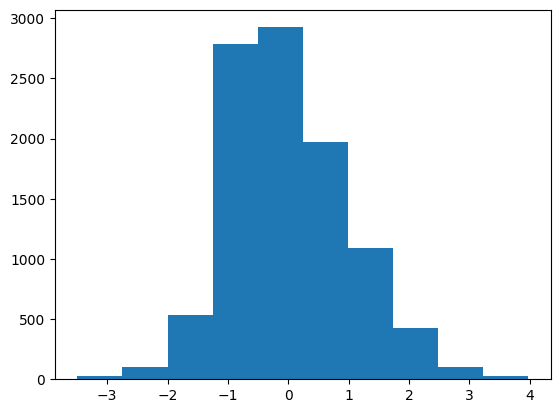

In [175]:
plt.hist(df["analysis/songs/tempo"])

(array([2.000e+00, 3.000e+00, 1.100e+01, 3.700e+01, 1.380e+02, 3.750e+02,
        1.095e+03, 2.936e+03, 4.560e+03, 8.430e+02]),
 array([-7.6224081 , -6.6554885 , -5.6885689 , -4.7216493 , -3.7547297 ,
        -2.78781011, -1.82089051, -0.85397091,  0.11294869,  1.07986829,
         2.04678788]),
 <BarContainer object of 10 artists>)

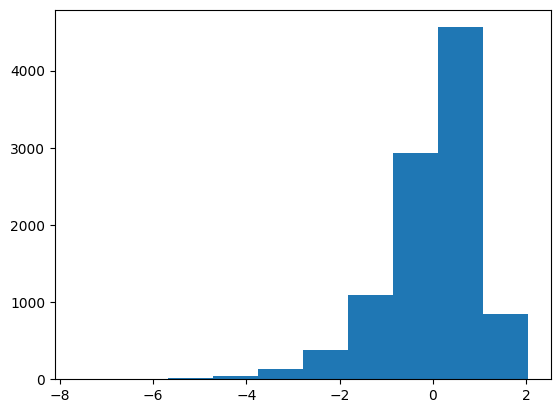

In [172]:
plt.hist(df["analysis/songs/loudness"])

(array([2.823e+03, 6.313e+03, 7.020e+02, 1.000e+02, 2.800e+01, 1.600e+01,
        8.000e+00, 4.000e+00, 3.000e+00, 3.000e+00]),
 array([-2.08060387, -0.48707502,  1.10645384,  2.69998269,  4.29351155,
         5.8870404 ,  7.48056926,  9.07409811, 10.66762697, 12.26115582,
        13.85468468]),
 <BarContainer object of 10 artists>)

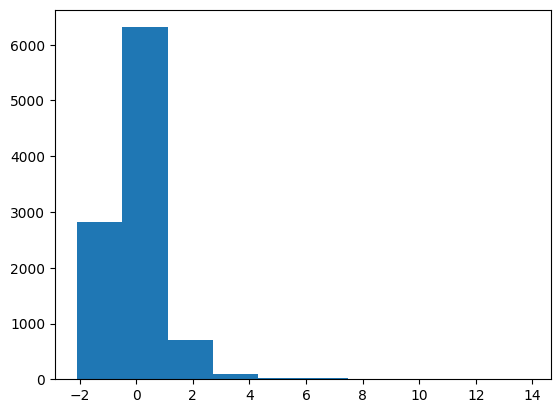

In [173]:
plt.hist(df["analysis/songs/duration"])

In [ ]:
import torch.nn as nn

embedding = nn.Embedding()